In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from model import AMIML
from dataloder_function import dataloader_function
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pickle
import random
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
import glob
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


file = "KIRC"
list1 = ["BAP1"]
list2 = ["TCGA-DV-A4W0-01Z-00-DX1.npy"]
for num in range(1):
    gene_rank = [list1[0]]
    name  = list2[num]
    #d_feature_path = "/data/TCGA_CPTAC/UCEC/TCGA_UCEC_xception_fine_tuned_feature"
    #d_feature_path = "/data/TCGA_CPTAC/BRCA_feature"
    #d_feature_path = "/data/TCGA_CPTAC/GBM/TCGA_GBM_xception_fine_tuned_feature_1116"
    d_feature_path = "./TCGA_CPTAC/KIRC/TCGA_KIRC_xception_fine_tuned_feature_1116"
    #thumb_path = "/data/gbw_other_data/TCGA_UCEC/thumb"
    #thumb_path = "/data/TCGA_CPTAC/TCGA_BRCA/thumb"
    #thumb_path = "/data/gbw/TCGA_CPTAC/TCGA-GBM/thumb"
    thumb_path = "./TCGA_CPTAC/TCGA_KIRC/thumb"
    def generate_location(file,gene_rank,name,d_feature_path):
        gpu_id = 1
        model_name = "AMIML"
        list_before = gene_rank
        count_triger = -1

        for t_gene in list_before:
            best_cluster = pd.read_csv("./Gene_Mut/" + file + "/TCGA/cluster/best_cluster.csv")
            c = best_cluster[best_cluster["gene"] == t_gene]["cluster"].item()
            for c in [c]:
                count_triger=count_triger+1
                AUC = []
                ACC = []
                torch.cuda.set_device(gpu_id )
                cv_splits = pickle.load(open("./Gene_Mut/"+file+"/TCGA/cluster/CLUSTER" + str(c) + "/" + t_gene + '/5fold_splits.pkl', 'rb'))
                feature_folder_path = "./Gene_Mut/"+file+"/TCGA/cluster/2048_cluster_"+ str(c)
                path_label_data = pd.read_csv("./Gene_Mut/"+file+"/TCGA/cluster/CLUSTER" + str(c) + "/" + str(t_gene) + "/path_label_ALL_" + str(t_gene) + "_"+file+".csv")
                feature_paths = path_label_data["path"].tolist()
                test_id = [feature_folder_path+"/"+name]
                for cv in range(5):
                    test_list = [feature_paths[i] for i in cv_splits[cv]["test_set"]]
                    for h in test_list:
                        if h==test_id[0]:
                            m=cv
                print(m)
                My_dataloader = dataloader_function(c, t_gene,file)
                test_data = My_dataloader(test_id, train=False)
                test_loader = test_data.get_loader()
                # cptac_test_data = My_dataloader(cptac, train=False)
                # cptac_test_loader = cptac_test_data.get_loader()
                model = AMIML(input_dim=256)
                model = model.cpu()
                model.load_state_dict(torch.load(
                    "./Gene_Mut/"+file+"/TCGA/cluster/CLUSTER" + str(c) + "/" + str(t_gene) + "/"+model_name+str(seed)+"model/weight_Best_MLP_model100" + str(m) + ".pkl"))
                # model.load_state_dict(torch.load("/data/TCGA_CPTAC/BRCA/CLUSTER/CLUSTER_New3/model/"+m_gene+"/weight_MLP_model100"+str(i)+".pkl"))
                model.train(False)

                for i_batch, sample_batch in enumerate(test_loader):
                    inputs = sample_batch["feat"]
                    labels = sample_batch["label"].squeeze(-1)
                    print(labels)
                    # name=sample_batch["name"]
                    #print(inputs.shape)
                    #print(labels.shape)
                    model.eval()
                    y_p,high_atten,high_atten_indice = model(inputs)  # 输出的label

        score = np.array(high_atten[0][0].detach().numpy())
        index = np.array(high_atten_indice[0][0].detach().numpy())

        flat_feature_path = "./Gene_Mut/"+file+"/TCGA/cluster/2048_cluster_"+ str(c)+"/"+str(name)
        feature_path = d_feature_path+"/"+name
        d_feature = np.load(feature_path)
        flat_feature = np.load(flat_feature_path)
        locations = []
        for m in range(len(index)):
            for i in range(d_feature.shape[0]):
                for j in range(d_feature.shape[1]):
                    if np.linalg.norm(d_feature[i][j]-flat_feature[m])==0:
                        location = [i,j]
                        locations.append(location)
                        break
        locations=np.array(locations)
        shape=d_feature.shape


        feature = pd.read_csv("./Gene_Mut/all_feature_with_position/"+file+"/csv_with_cluster/"+name[0:-4]+".csv")
        feature = np.array(feature)
        xx= feature[:,-3:]
        data = pd.DataFrame(xx,columns=["x","y","cluster"])
        data_x=np.array(data[data["cluster"]==c])
        return score,locations,d_feature.shape,data_x

    score,locations,shape,data_x=generate_location(file,gene_rank,name,d_feature_path)

HE2RNA(
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (conv1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(32, 8, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
  (conv6): ConvTranspose1d(1, 8, kernel_size=(1,), stride=(1,))
  (bn5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (query): Linear(in_features=8, out_features=8, bias=True)
  (key): Linear(in_features=8, out_features=8, bias=True)
  (value)

In [80]:
def add_right_cax(ax, pad, width):
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x0 ,
        axpos.y0- pad,
        axpos.x1 ,
        axpos.y1- pad - width
    )
    cax = ax.figure.add_axes(caxpos)

    return cax
viridis_big = cm.get_cmap('Reds', 256)
newcmp = ListedColormap(viridis_big(np.linspace(0, 0.75, 256)))

<Figure size 8000x8000 with 0 Axes>

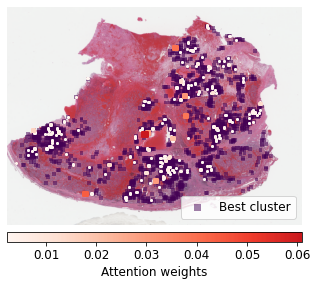

In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
dataframe = pd.read_csv("./Gene_Mut/"+file+"/TCGA/tcga_"+file+"_slide_information.csv")
datalist = os.listdir(thumb_path)
for i in datalist:
    if i[0:23]==name[0:23]:
        thumb_name = i

plt.figure(dpi=400,figsize=(20,20))
plt.rcParams['axes.facecolor']='white'
img=plt.imread(thumb_path+"/"+thumb_name)
fig,ax=plt.subplots()
ax.imshow(img,extent=[0,shape[1],-shape[0],0])
plt.axis('off')
plt.xticks([])
plt.yticks([])
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerLine2D
def update_scatter(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([16])
Best_cluster = plt.scatter(data_x[:, 1], -data_x[:, 0],c=[3]*len(data_x[:, 1]),s=15,alpha=0.5,marker='s',label='Best cluster',linewidths=0)
plt.legend(fontsize=12,loc="lower right",markerscale=1.6)
#plt.legend(fontsize=14,handles=[Best_cluster],loc="lower right",markerscale=1,handler_map={PathCollection: HandlerPathCollection(update_func=update_scatter),})
#plt.scatter(data_x[:, 1], -data_x[:, 0], c="Black",s=2,marker='s')
im = plt.scatter(locations[:,1], -locations[:,0], marker='s',s=500*score ,c=score ,linewidth=2,cmap=newcmp,linewidths=0)
#plt.colorbar(label="Attention weights", orientation="horizontal",fraction=0.05) 
cax = add_right_cax(ax,pad=0.06, width=0.72)
cbar = fig.colorbar(im,label="Attention weights", orientation="horizontal",fraction=0.05, cax=cax)
font = {
        'weight' : 'normal',
        'size'   : 12,
        }
cbar.set_label("Attention weights",fontdict=font)
cbar.ax.tick_params(labelsize=12)
#plt.title('s=fea*100, c=purple',verticalalignment='bottom')
save_path = "./Gene_Mut/all_feature_with_position/KIRC/mut_vs_wild/high_equality/"+gene_rank[0]+name[:-4]
if not os.path.exists(save_path):
    os.mkdir(save_path) 
plt.savefig("./Gene_Mut/all_feature_with_position/KIRC/mut_vs_wild/high_equality/"+gene_rank[0]+name[:-4]+"/"+file+"_"+gene_rank[0]+"_"+name[0:12]+"high_eq"+".tif",dpi=100, bbox_inches = 'tight')
plt.show()




In [763]:
def draw_the_patch(count,file,gene,name,location):
    #feature_dimension = feature.shape[2]
    mpp = 0.5
    patch_save_type = ".tif"
    input_patch_size = 224
    # patient_name = tensor_name[0:12]  # e.g. TCGA-3L-AA1B
    # print("Debug patient name:", patient_name)
    # WSI_location = glob.glob(WSI_folder_path + "/*/" + patient_name + "-01Z-00-DX1" + "*")[0]
    WSI_excel_path = "/data/gbw/Gene_Mut/"+file+"/TCGA/tcga_"+file+"_slide_information.csv"
    data_summary = pd.read_csv(WSI_excel_path)
    patient_name = name
    if len(patient_name)==12:
        slide_name = patient_name + "-01Z-00-DX1"
    else:
        slide_name = patient_name
    patient_information = data_summary[(data_summary['patient_name'] == slide_name)]  # get row
    WSI_mpp = patient_information["MPP"]
    WSI_location=patient_information["svs_paths"]
    if len(WSI_mpp)!=0:
        patch_pixel = round(input_patch_size * mpp / float(WSI_mpp))
        slide = openslide.open_slide(WSI_location.item())
        maxCRef = np.load("/data/gbw/NN2class/NEW_result/maxCRef.npy")
        HERef = np.load("/data/gbw/NN2class/NEW_result/HERef.npy")
        patch_save_folder_path = "/data/gbw/Gene_Mut/all_feature_with_position/UCEC/high_and_low_attention/"+file
        if not os.path.exists(patch_save_folder_path):
            os.mkdir(patch_save_folder_path)
        gene_patch_save_folder_path = patch_save_folder_path+"/"+gene
        if not os.path.exists(gene_patch_save_folder_path):
            os.mkdir(gene_patch_save_folder_path)
        patient_patch_save_folder_path = gene_patch_save_folder_path+"/"+str(name)
        if not os.path.exists(patient_patch_save_folder_path):
            os.mkdir(patient_patch_save_folder_path)

        location_col=location[1]
        location_row=location[0]
        patch = slide.read_region((location_col * patch_pixel, location_row * patch_pixel), 0, (patch_pixel, patch_pixel))  
        np_patch = np.array(patch)
        np_patch = cv.cvtColor(np_patch, cv.COLOR_RGBA2RGB)
        np_patch = cv.resize(np_patch, (224, 224))
        try:
            img = normal_Macenko(np_patch, HERef, maxCRef, Io=255, alpha=1, beta=0.15)
            img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
            cv.imwrite(patient_patch_save_folder_path+"/"+str(count)+name+"_"+"["+str(location[0])+","+str(location[1])+"]_"+patch_save_type, img)
        except:
            m=m+1
    else:
        print(patient_name+"have deleted!")

In [ ]:

count = -1
for location in locations:
    count=count+1
    draw_the_patch(count,file,gene_rank[0],name[:-4],location)

In [762]:
def normal_Macenko(img, HERef, maxCRef, Io=255, alpha=1, beta=0.15):

    img = img.astype(np.float64)
    # define height and width of image
    h, w, c = img.shape

    # reshape image
    img = img.reshape((-1, 3))

    # calculate optical density
    OD = -np.log((img.astype(np.float64) + 1) / Io)

    OD = OD.astype(np.float64)
    # remove transparent pixels
    ODhat = OD[~np.any(OD < beta, axis=1)]

    # compute eigenvectors
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

    # project on the plane spanned by the eigenvectors corresponding to the two
    # largest eigenvalues
    That = ODhat.dot(eigvecs[:, 1:3])

    phi = np.arctan2(That[:, 1], That[:, 0])

    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)

    vMin = eigvecs[:, 1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:, 1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)

    # a heuristic to make the vector corresponding to hematoxylin first and the
    # one corresponding to eosin second

    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:, 0], vMax[:, 0])).T
    else:
        HE = np.array((vMax[:, 0], vMin[:, 0])).T

    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T

    # add a dimension according to the MATLAB code
    # by cross the H & E

    HE2 = np.cross(HE[:, 0], HE[:, 1])
    HE2 = HE2 / (HE2 ** 2).sum() ** 0.5
    HE = np.column_stack((HE, HE2))

    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE, Y, rcond=None)[0]

    # normalize stain concentrations

    maxC = np.array([np.percentile(C[0, :], 99), np.percentile(C[1, :], 99), np.percentile(C[2, :], 99)])

    tmp = np.divide(maxC, maxCRef)

    C2 = np.divide(C, tmp[:, np.newaxis])

    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))

    Inorm[Inorm > 255] = 254

    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)

    return Inorm

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
cancer = "KIRC"
name = "TCGA-CJ-4923-01Z-00-DX1"
list1 = ["ATM"]
gene_rank = [list1[0]]
feature = pd.read_csv("/data/gbw/Gene_Mut/all_feature_with_position/"+cancer+"/csv_with_cluster/"+str(name)+".csv")
feature = np.array(feature)
xx= feature[:,-3:]
plt.figure(facecolor='black',edgecolor='black')
plt.scatter(xx[:, 1], -xx[:, 0], c=xx[:, 2], s=1,cmap=cmap)
plt.axis('off')
plt.draw()
save_path = "/data/gbw/Gene_Mut/all_feature_with_position/UCEC/mut_vs_wild/scatter_plot/"+gene_rank[0]+name
if not os.path.exists(save_path):
    os.mkdir(save_path) 
plt.savefig("/data/gbw/Gene_Mut/all_feature_with_position/UCEC/mut_vs_wild/scatter_plot/"+gene_rank[0]+name+"/"+str(i)+".png")
plt.pause(1)
plt.close()

for j in range(4):
    data = pd.DataFrame(xx,columns=["x","y","cluster"])
    data_x=np.array(data[data["cluster"]==j+1])
    cmap = mpl.cm.get_cmap("Oranges_r", 4)
    newcolors = cmap(np.linspace(0, 1, 4)[j])
    newcmp = ListedColormap(newcolors)
    plt.figure(facecolor='black',edgecolor='black')
    plt.scatter(data_x[:, 1], -data_x[:, 0], c=data_x[:, 2],s=1,cmap=newcmp)
    plt.axis('off')
    plt.draw()
    plt.savefig("/data/gbw/Gene_Mut/all_feature_with_position/UCEC/mut_vs_wild/scatter_plot/"+gene_rank[0]+name+"/"+str(i)+str(j)+".png")
    plt.pause(1)
    plt.close()